In [1]:
import torch 
import numpy as np

from nltk.tokenize import sent_tokenize 

from pathlib import Path 
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
from mingpt.bpe import BPETokenizer 
from mingpt.utils import set_seed 
set_seed(1234)

from utils import *
from SentimentDataset import SentimentDataset

cuda==False


In [4]:
# Instantiate the Training Dataset
train_dataset = SentimentDataset(split="train")  # use this for the short corpus

# Instantiate a Validation Dataset (this is only really needed for the fine-tune task, not the LM task)
val_dataset = SentimentDataset(split="validation")

In [7]:
# Print out an example of the data - this is processed more once it reaches lm_collate_fn (above)
x,y = train_dataset[5]
print(train_dataset[5])
print("X: ",train_dataset.tokenizer.decode(x))
print("Y: ",(y))

(tensor([ 5562,   705,    82,  1290,  1165, 15444,   284, 17004,   884, 31194,
         3513,   220]), 0)
X:  that 's far too tragic to merit such superficial treatment 
Y:  0


In [8]:
from mingpt.model import GPT

model_config = GPT.get_default_config()
model_config.model_type = 'gpt-nano'
model_config.vocab_size = train_dataset.get_vocab_size()
model_config.block_size = train_dataset.get_block_size()
model_config.n_classification_class = 2
model = GPT(model_config)
# model.to(trainer.device)

modelsavename= "model_large100K.pt"
model.load_state_dict(torch.load(modelsavename, map_location=torch.device('cpu')))

number of parameters: 2.52M


<All keys matched successfully>

In [9]:
# Create a Trainer object and set the core hyper-parameters
from mingpt.trainer import Trainer

train_config = Trainer.get_default_config()
train_config.learning_rate = 5e-4 # the model we're using is so small that we can go a bit faster
train_config.max_iters = 3000  # For small corpus: 3000 iterations is plenty. For large corpus: 100000 iterations is needed
train_config.num_workers = 0
train_config.batch_size = 8    # For small corpus, batch size of 4 is fine.  For large corpus use 16
trainer = Trainer(train_config, model, train_dataset, val_dataset, collate_fn=sen_collate_fn, downstream_finetune=True)
trainer.set_callback('on_batch_end', sen_batch_end_callback)
# Train!
trainer.run()

running on device cpu
iter0 0.00ms; train loss 2.85043 acc 0.750; val loss 10.51701 acc 0.500;
iter100 15.99ms; train loss 1.66561 acc 0.375; val loss 0.88466 acc 0.500;
iter200 15.24ms; train loss 0.77795 acc 0.500; val loss 0.68070 acc 0.625;
iter300 15.73ms; train loss 0.83244 acc 0.375; val loss 0.70196 acc 0.750;
iter400 17.15ms; train loss 0.54560 acc 0.875; val loss 0.86615 acc 0.375;
iter500 18.56ms; train loss 0.98936 acc 0.500; val loss 1.14535 acc 0.375;
iter600 15.63ms; train loss 0.50502 acc 0.750; val loss 0.48986 acc 0.750;
iter700 19.38ms; train loss 0.60935 acc 0.625; val loss 0.83264 acc 0.375;
iter800 18.90ms; train loss 0.63524 acc 0.750; val loss 1.19784 acc 0.125;
iter900 14.57ms; train loss 0.71537 acc 0.625; val loss 0.35085 acc 0.875;
iter1000 15.15ms; train loss 0.46942 acc 0.750; val loss 0.64872 acc 0.500;
iter1100 15.91ms; train loss 0.50093 acc 0.625; val loss 0.72734 acc 0.750;
iter1200 17.19ms; train loss 0.74298 acc 0.375; val loss 0.59389 acc 0.625;
it

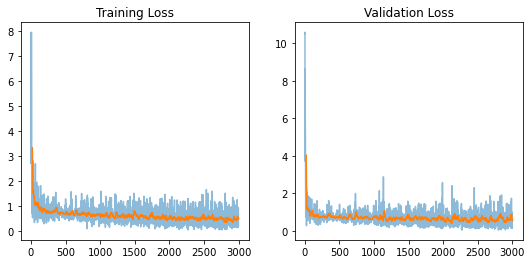

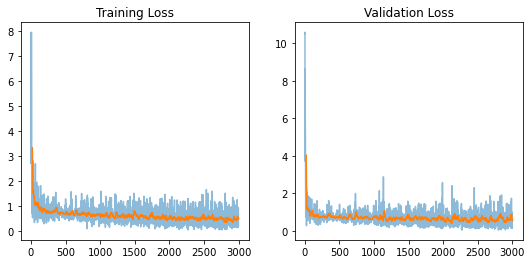

In [10]:
plot_loss(trainer)

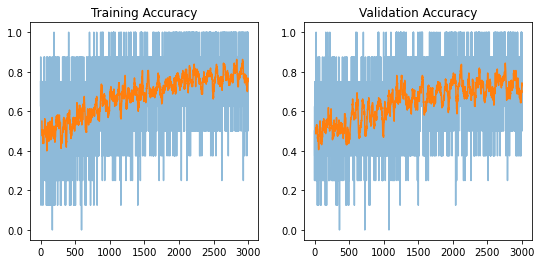

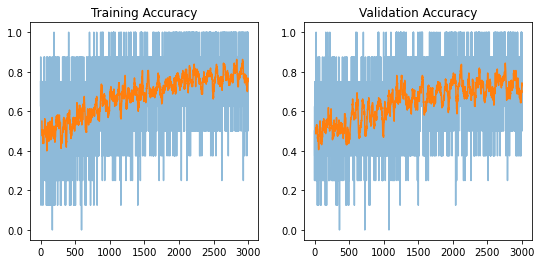

In [12]:
plot_acc(trainer)